In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = './data/f1_data_processed.csv'

In [4]:
def data_loader(file_path, columns_to_include, categorical_cols):
    """
    Load and preprocess the dataset by selecting specific columns, handling missing values,
    converting time-related columns to seconds, flagging missing values, and processing categorical variables

    Parameters:
    file_path (str): The path to the CSV file
    columns_to_include (list): List of columns to include in the final DataFrame
    categorical_cols (list): List of categorical columns

    Returns:
    pd.DataFrame: Preprocessed DataFrame
    """
    df = pd.read_csv(file_path)
    
    # Select the specified columns
    df = df[columns_to_include]

    # drop rows with nan time
    df = df.dropna(subset=['Time'])
    
    # # Convert RaceDate to datetime
    # df['RaceDate'] = pd.to_datetime(df['RaceDate'])
    
    # Convert Q1_Qual, Q2_Qual, Q3_Qual to seconds
    for col in ['Q1_Qual', 'Q2_Qual', 'Q3_Qual']:
        df[col] = pd.to_timedelta(df[col], errors='coerce').dt.total_seconds()
    
    # Flag missing values and fill them with a placeholder (e.g., max_time + 10)
    for col in ['Q1_Qual', 'Q2_Qual', 'Q3_Qual']:
        # Create a flag column
        df[f'{col}_missing'] = df[col].isnull().astype(int)
        
        # Impute missing values with a high value
        max_time = df[col].max() if not np.isnan(df[col].max()) else 0
        df[col].fillna(max_time + 10, inplace=True)
    
    # Process categorical variables with one-hot encoding
    # categorical_cols = ['DriverId', 'TeamId', 'RaceName', 'Year']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    return df

In [5]:
def split_data(df, target_column):
    """
    Split the data into training and testing sets

    Parameters:
    df (pd.DataFrame): The preprocessed DataFrame
    target_column (str): The name of the y column

    Returns:
    tuple: X_train, X_test, y_train, y_test
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on the test set

    Parameters:
    model: Trained model
    X_test (pd.DataFrame): Test features
    y_test (pd.Series): Test target

    Returns:
    None
    """
    predictions = model.predict(X_test)
    print("Mean Absolute Error:", mean_absolute_error(y_test, predictions))
    print("R^2 Score:", r2_score(y_test, predictions))

### Training Preparation 

In [7]:
columns_to_include = ['DriverId', 'TeamId', 'GridPosition', 'Position_Qual', 'Q1_Qual', 
                      'Q2_Qual', 'Q3_Qual', 'AirTemp', 'Humidity', 'Pressure',
                      'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Year',
                      'RaceName', 'TotalLength', 'Time']
categorical_cols = ['DriverId', 'TeamId', 'RaceName', 'Year']

In [8]:
df = data_loader(file_path, columns_to_include, categorical_cols)
df.head(5)

,GridPosition,Position_Qual,Q1_Qual,Q2_Qual,Q3_Qual,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,...,RaceName_Sakhir Grand Prix,RaceName_Singapore Grand Prix,RaceName_Spanish Grand Prix,RaceName_Styrian Grand Prix,RaceName_Turkish Grand Prix,RaceName_Tuscan Grand Prix,RaceName_United States Grand Prix,Year_2019,Year_2020,Year_2021
0,3,3.0,83.348,81.944,81.838,24.077477,30.915315,997.003604,0.045045,36.324324,...,False,False,False,False,False,False,False,False,False,False
1,1,1.0,82.824,82.051,81.164,24.077477,30.915315,997.003604,0.045045,36.324324,...,False,False,False,False,False,False,False,False,False,False
2,2,2.0,83.096,82.507,81.828,24.077477,30.915315,997.003604,0.045045,36.324324,...,False,False,False,False,False,False,False,False,False,False
3,8,5.0,83.494,82.897,82.152,24.077477,30.915315,997.003604,0.045045,36.324324,...,False,False,False,False,False,False,False,False,False,False
4,10,11.0,83.597,83.692,134.933,24.077477,30.915315,997.003604,0.045045,36.324324,...,False,False,False,False,False,False,False,False,False,False


In [9]:
X_train, X_test, y_train, y_test = split_data(df, 'Time')

### Model Comparison

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [34]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Cross-validation results
results = []

for name, model in models.items():
    # Cross-validation with 5 folds
    mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Calculate the mean and standard deviation for each metric
    mean_mae = mae_scores.mean()
    std_mae = mae_scores.std()
    mean_r2 = r2_scores.mean()
    std_r2 = r2_scores.std()
    
    results.append((name, mean_mae, std_mae, mean_r2, std_r2))

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=["Model", "Mean MAE", "MAE Std Dev", "Mean R²", "R² Std Dev"])
print(results_df)

               Model    Mean MAE  MAE Std Dev   Mean R²  R² Std Dev
0  Linear Regression  374.602382    51.125186  0.654194    0.101653
1   Ridge Regression  395.718867    49.855441  0.636424    0.047600
2   Lasso Regression  365.561512    49.799283  0.679063    0.065072
3      Random Forest   29.814390     5.838784  0.996518    0.001362
4            XGBoost   36.423758    13.985435  0.949982    0.090252


### Random Forest Regressor

In [10]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importances and feature names
rf_importances = rf_model.feature_importances_
features = X_train.columns

# Create DataFrame to view the importances
rf_importance_df = pd.DataFrame({'Feature': features, 'Importance': rf_importances})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

print(rf_importance_df.head(5))

                          Feature  Importance
11                      WindSpeed    0.325548
90     RaceName_Tuscan Grand Prix    0.180922
5                         AirTemp    0.084283
86  RaceName_Singapore Grand Prix    0.064295
10                  WindDirection    0.049865


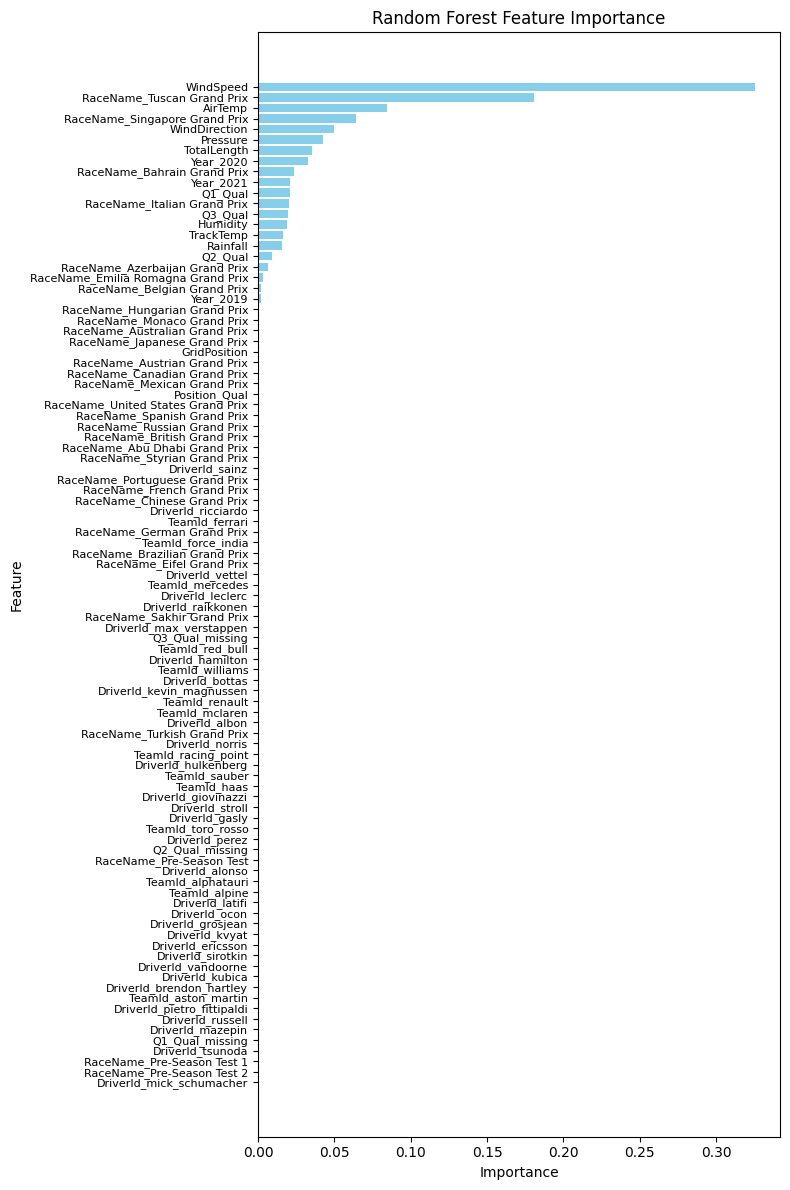

In [14]:
# Random Forest Feature Importances
plt.figure(figsize=(8, 12))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='skyblue')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
# Adjusting font size for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [16]:
evaluate_model(rf_model, X_test, y_test)

Mean Absolute Error: 28.940006240601125
R^2 Score: 0.9914947710576589


### XGBoost Regressor

In [20]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Extract feature importances and feature names
xgb_importances = xgb_model.feature_importances_
features = X_train.columns

# Create DataFrame to view the importances
xgb_importance_df = pd.DataFrame({'Feature': features, 'Importance': xgb_importances})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)

print(xgb_importance_df.head(5))

                          Feature  Importance
90     RaceName_Tuscan Grand Prix    0.544800
86  RaceName_Singapore Grand Prix    0.256643
11                      WindSpeed    0.074638
76    RaceName_Italian Grand Prix    0.027355
12                    TotalLength    0.021305


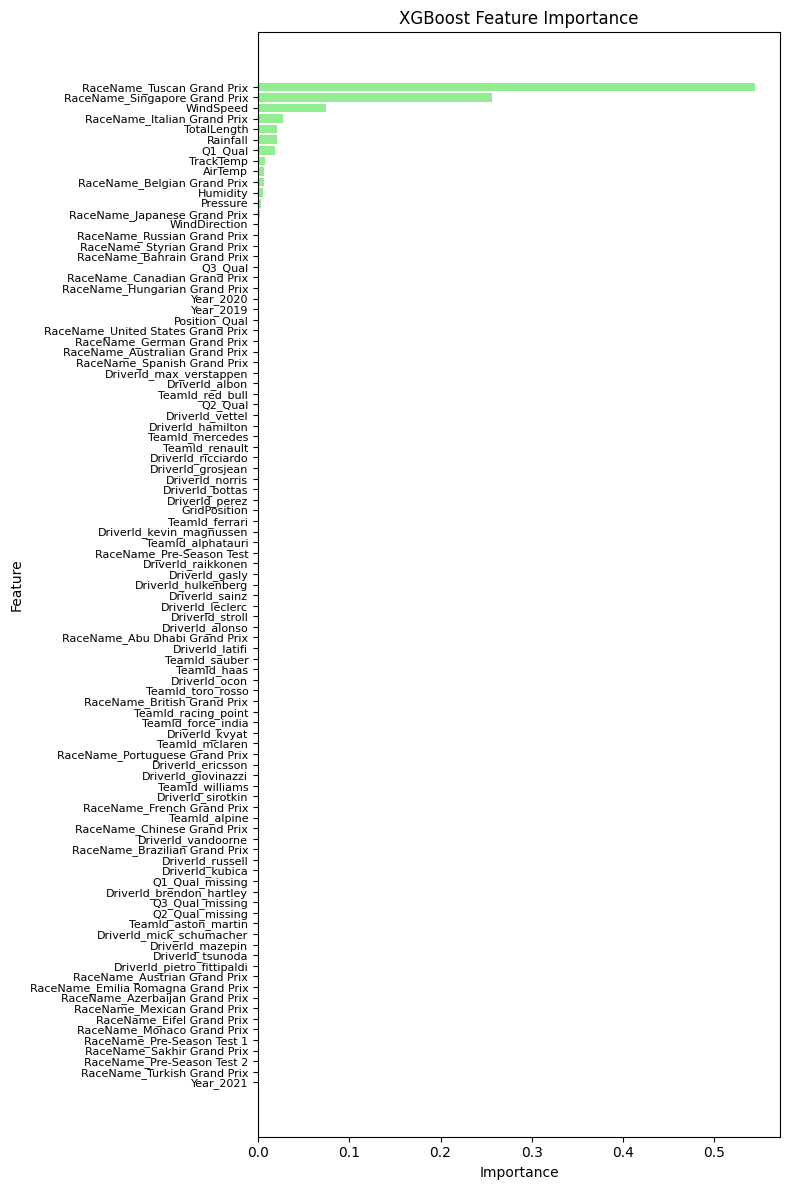

In [21]:
# XGBoost Feature Importances
plt.figure(figsize=(8, 12))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='lightgreen')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
# Adjusting font size for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [22]:
evaluate_model(xgb_model, X_test, y_test)

Mean Absolute Error: 50.92326709351503
R^2 Score: 0.8258230817184994


: 